
 Domain: BANK

Model: LogisticRegression


PermutationExplainer explainer: 56747it [49:06, 19.26it/s]                                     


Global Feature Importance


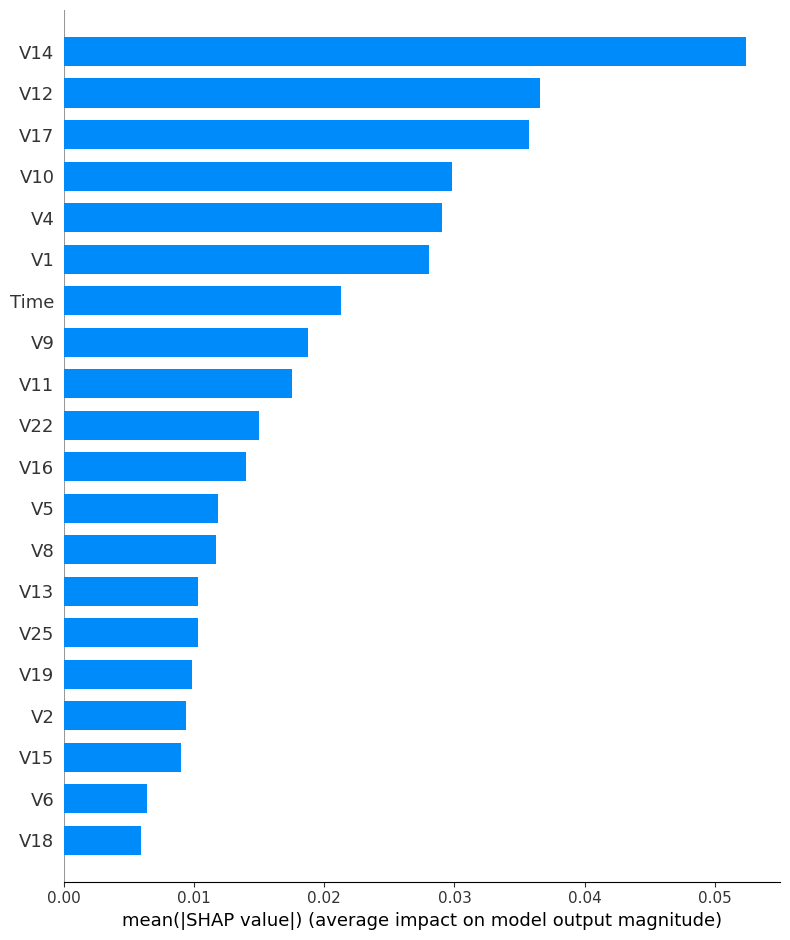

📎 Local Explanation


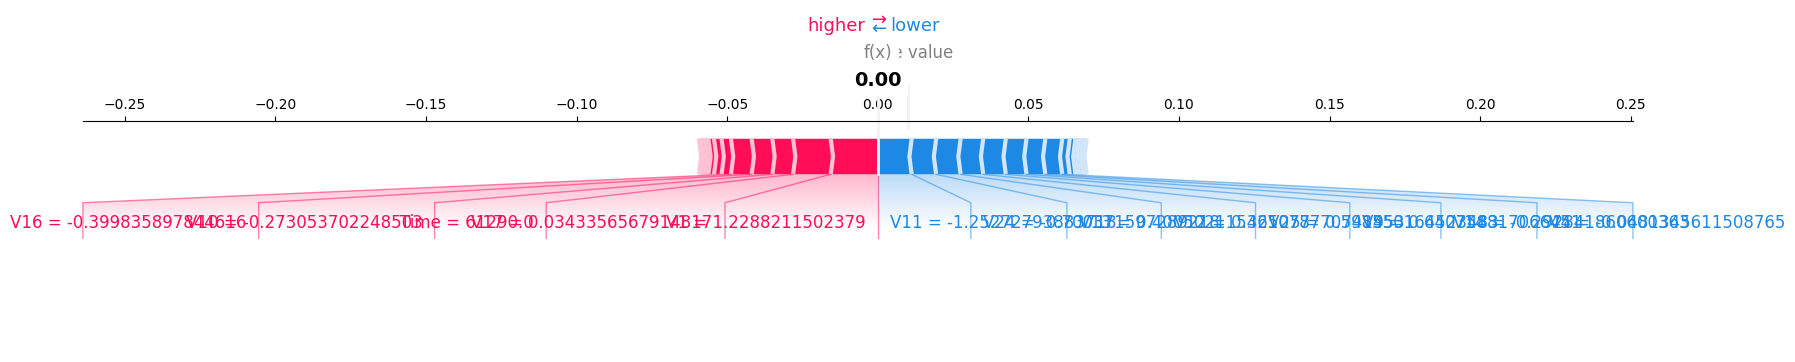

Waterfall Plot


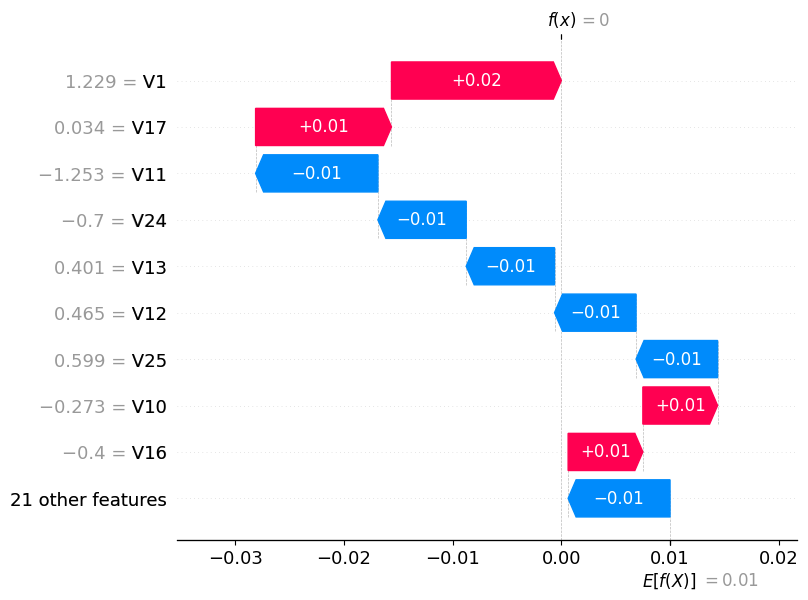


Model: XGBoost
Global Feature Importance


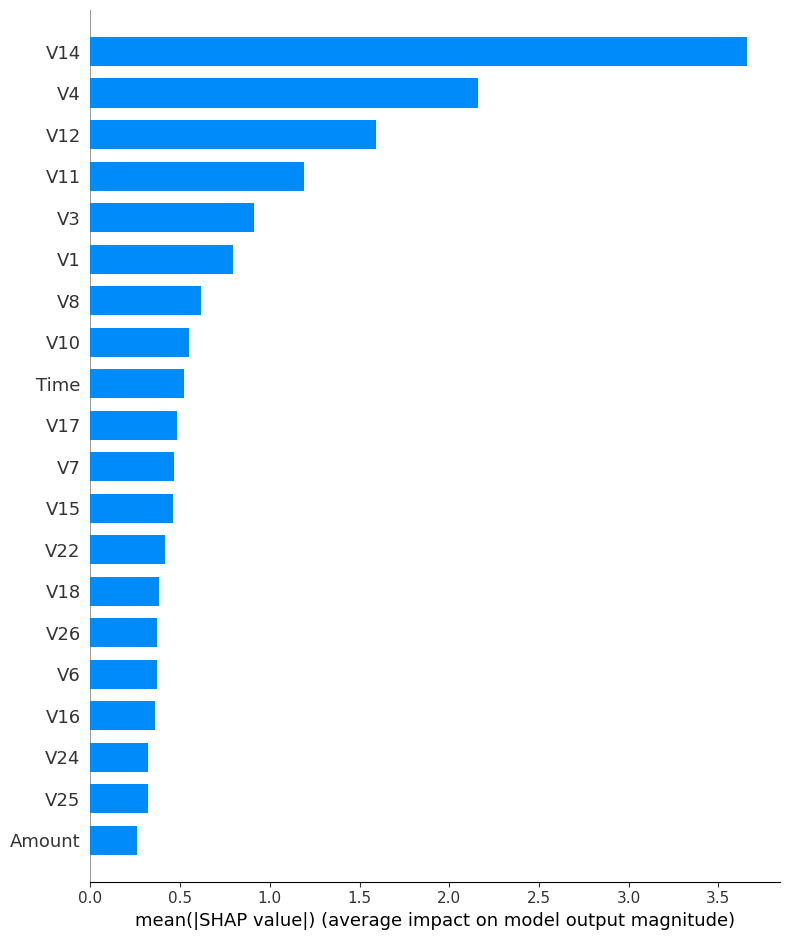

📎 Local Explanation
⚠️ SHAP Force Plot Error: 'numpy.ndarray' object has no attribute 'values'
Waterfall Plot
⚠️ Waterfall plot failed: The waterfall plot requires an `Explanation` object as the `shap_values` argument.

 Domain: ECOM

Model: LogisticRegression


ExactExplainer explainer: 30224it [03:19, 148.13it/s]                                          


Global Feature Importance


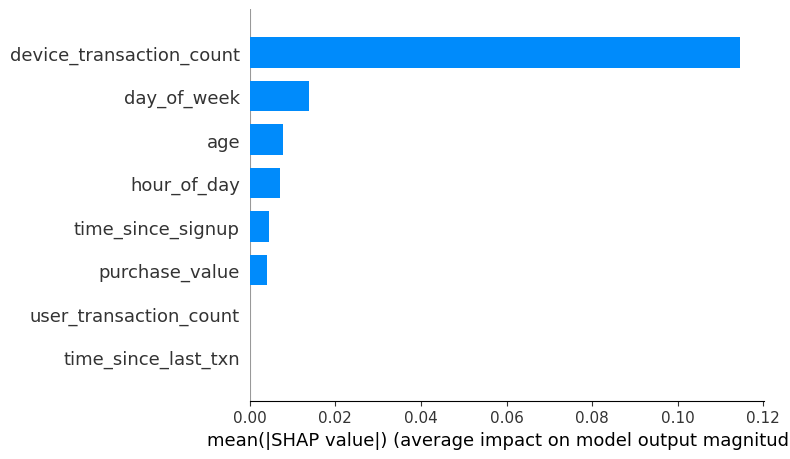

📎 Local Explanation


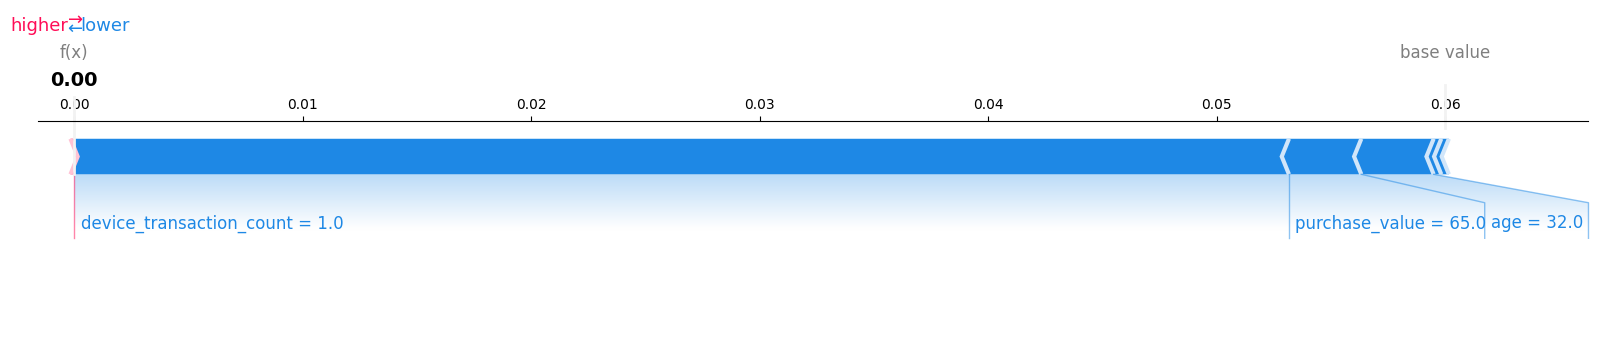

Waterfall Plot


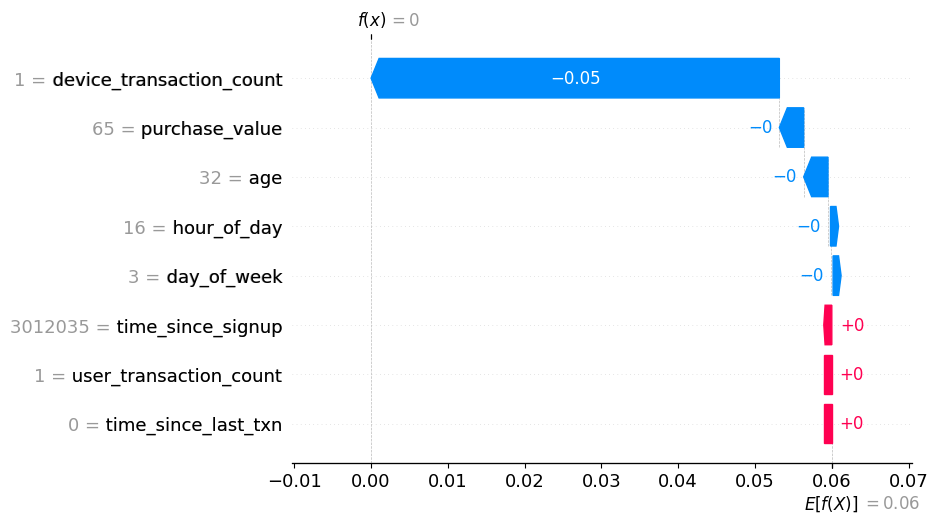


Model: XGBoost
Global Feature Importance


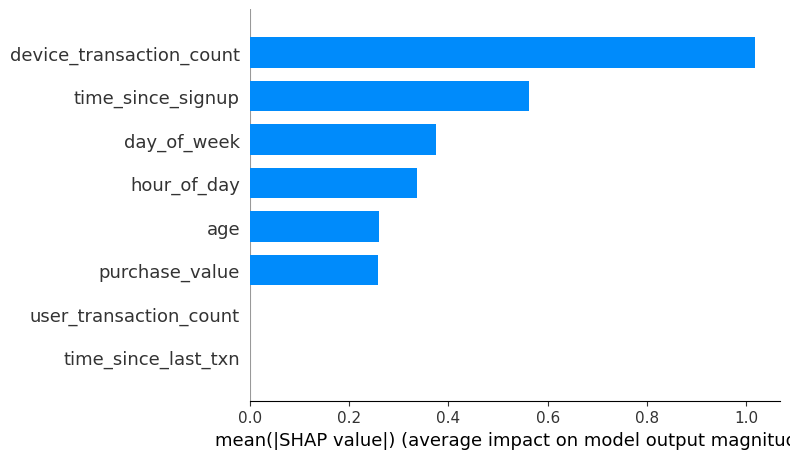

📎 Local Explanation
⚠️ SHAP Force Plot Error: 'numpy.ndarray' object has no attribute 'values'
Waterfall Plot
⚠️ Waterfall plot failed: The waterfall plot requires an `Explanation` object as the `shap_values` argument.


In [1]:
import shap
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
shap.initjs()

# Configuration
config = {
    "bank": {
        "models": {
            "LogisticRegression": "../artifacts/bank/Logistic Regression.pkl",
            "XGBoost": "../artifacts/bank/XGBoost.pkl"
        },
        "data": "../data/processed/bank_X_test.csv"
    },
    "ecom": {
        "models": {
            "LogisticRegression": "../artifacts/ecom/Logistic Regression.pkl",
            "XGBoost": "../artifacts/ecom/XGBoost.pkl"
        },
        "data": "../data/processed/ecom_X_test.csv"
    }
}

# 🔄 Iterate through domains and models
for domain, domain_cfg in config.items():
    print(f"\n Domain: {domain.upper()}")

    # 📦 Load test data
    X_test = pd.read_csv(domain_cfg["data"])
    X_numeric = X_test.copy()

    for model_name, model_path in domain_cfg["models"].items():
        print(f"\nModel: {model_name}")
        model = joblib.load(model_path)

        # 🛠 Feature alignment
        if hasattr(model, "n_features_in_"):
            model_features = getattr(model, "feature_names_in_", None)
            if model_features is not None:
                X_numeric = X_numeric[model_features]

        # 📊 SHAP explainer setup
        if "XGBoost" in model_path or model.__class__.__name__ == "XGBClassifier":
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_numeric)
        else:
            explainer = shap.Explainer(model.predict, X_numeric)
            shap_values = explainer(X_numeric)

        # 🌍 Global Feature Importance
        print("Global Feature Importance")
        shap.summary_plot(shap_values, X_numeric, plot_type="bar")

        # 📎 Local Explanation — Safe Force Plot
        print("📎 Local Explanation")
        try:
            instance_index = 0
            base_value = (
                explainer.expected_value if hasattr(explainer, "expected_value")
                else shap_values.base_values[instance_index]
            )

            shap.force_plot(
                base_value,
                shap_values.values[instance_index],
                X_numeric.iloc[instance_index],
                matplotlib=True
            )

        except Exception as e:
            print(f"⚠️ SHAP Force Plot Error: {e}")

        # 💧 Waterfall Plot
        print("Waterfall Plot")
        try:
            shap.plots.waterfall(shap_values[instance_index])
        except Exception as e:
            print("⚠️ Waterfall plot failed:", e)
